In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the drive

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy

os.chdir(os.path.join(basedir, 'neuralClosureModels'))

### Load modules

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
import src.advec_diff_case.advec_diff_eqn_modcall as adeq
import src.advec_diff_case.advec_diff_eqn_LES as les
from src.advec_diff_case.AD_Eqn_Helper_Classes import * 

import time
import sys
import os
from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import scipy as spy

tf.keras.backend.set_floatx('float32')

## Define some useful classes

In [13]:
### Define a custom plotting function
class custom_plot:

    def __init__(self, x, t):
        self.t = t
        self.X, self.T = np.meshgrid(x.numpy(), t.numpy())
        self.x = x
            
    def plot(self, u, title='Hello'):
        fig = plt.figure(figsize=(7, 4.5), facecolor='white')
        ax_u_lowres = fig.add_subplot(111)
        
        ax_u_lowres.cla()
        ax_u_lowres.set_title(title, fontsize=14)
        ax_u_lowres.set_xlabel('x', fontsize=14)
        ax_u_lowres.set_ylabel('t', fontsize=14)
        plot = ax_u_lowres.contourf(self.X, self.T, u, cmap=cm.coolwarm,
                           antialiased=False, levels=np.linspace(0, 0.5, 40), extend='min')
        ax_u_lowres.set_xlim(self.x[0], self.x[-1])
        ax_u_lowres.set_ylim(self.t[0], self.t[-1])
        plt.colorbar(plot, ax=ax_u_lowres, shrink=0.5, aspect=10)
        
        plt.show
        
    def pair(self, u1, title1, u2, title2):
        fig = plt.figure(figsize=(14, 4.5), facecolor='white')
        ax_u1 = fig.add_subplot(121)
        ax_u2 = fig.add_subplot(122)
        
        ax_u1.cla()
        ax_u1.set_title(title1, fontsize=14)
        ax_u1.set_xlabel('x', fontsize=14)
        ax_u1.set_ylabel('t', fontsize=14)
        plot = ax_u1.contourf(self.X, self.T, u1, cmap=cm.coolwarm,
                           antialiased=False, levels=np.linspace(0, 0.5, 40), extend='min')
        ax_u1.set_xlim(self.x[0], self.x[-1])
        ax_u1.set_ylim(self.t[0], self.t[-1])
        plt.colorbar(plot, ax=ax_u1, shrink=0.5, aspect=10)
        
        ax_u2.cla()
        ax_u2.set_title(title2, fontsize=14)
        ax_u2.set_xlabel('x', fontsize=14)
        ax_u2.set_ylabel('t', fontsize=14)
        plot = ax_u2.contourf(self.X, self.T, u2, cmap=cm.coolwarm,
                           antialiased=False, levels=np.linspace(0, 0.5, 40), extend='min')
        ax_u2.set_xlim(self.x[0], self.x[-1])
        ax_u2.set_ylim(self.t[0], self.t[-1])
        plt.colorbar(plot, ax=ax_u2, shrink=0.5, aspect=10)
        
        plt.show

## Main part starts here

## Solve for high-resolution

In [5]:
app = adeq.ad_eqn_args(T = 5.0, nt = 500, L = 1., nx = 100, Re = 1000, u_bc_0 = 0., u_bc_L =0., multi_solve_size = 1)

x = tf.linspace(0., app.L, app.nx)
u0 = initial_cond(x, app) # Initial conditions
t = tf.linspace(0., app.T, app.nt) # Time array

op = adeq.operators(app)

u = ddeinttf(adeq.ad_eqn(op, app), u0, t, alg_name = 'vode', nsteps = -1)

## Solve for the LES model

In [6]:
app_les = les.ad_eqn_args(T = 5.0, nt = 500, L = 1., nx = 25, Re = 1000, u_bc_0 = 0., u_bc_L =0., multi_solve_size = 1, Cs = 1.)

x_les = tf.linspace(0., app_les.L, app_les.nx)
u0_les = initial_cond(x_les, app_les) # Initial conditions
t_les = tf.linspace(0., app_les.T, app_les.nt) # Time array

op_les = les.operators(app_les)

u_les = ddeinttf(les.ad_eqn(op_les), u0_les, t_les, alg_name = 'vode', nsteps = -1)

### Plots for Smagorinsky model

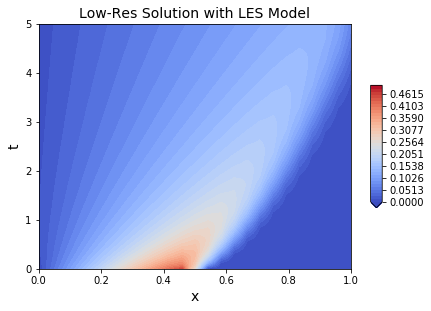

In [15]:
cp = custom_plot(x_les, t_les)

cp.plot(tf.squeeze(u_les, axis=1).numpy(), 'Low-Res Solution with LES Model')

## Difference between high-res solution interp on low-res grid and LES model

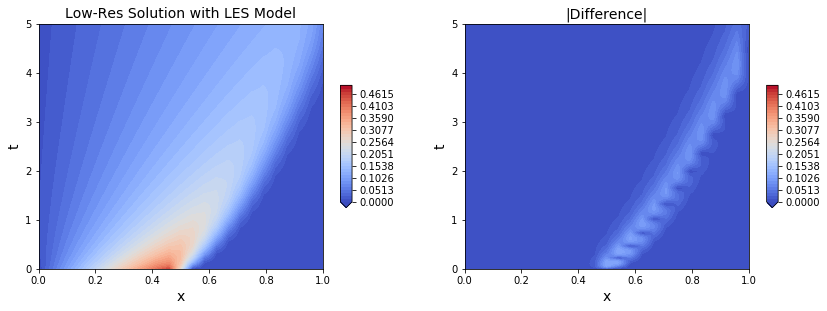

In [14]:
X_les, T_les = np.meshgrid(x_les.numpy(), t_les.numpy())

f = spy.interpolate.interp2d(x, t, tf.squeeze(u, axis=1).numpy(), kind='cubic')

cp = custom_plot(x_les, t_les)

cp.pair(tf.squeeze(u_les, axis=1).numpy(), 'Low-Res Solution with LES Model', tf.abs(f(x_les, t_les) - tf.squeeze(u_les, axis=1)).numpy(), '|Difference|')

## Compute Errors for the LES model

In [9]:
class compute_error():
    
    def __init__(self, truth, thres = 0.02):
        self.truth = truth
        self.thres = thres
        
    def l2_error(self, pred):
        
        error = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.math.squared_difference(pred, self.truth), axis=-1)), axis=0)
        
        return error.numpy()
    
    def RMSE(self, pred):
        
        thres = tf.reduce_max(self.truth)*0.02
        error = []
        diff = pred - self.truth
        
        for i in range(1, pred.shape[0]):
            diff_t = np.abs(np.squeeze(diff[i, :, :].numpy()))
            error_t = diff_t[np.where(diff_t >= thres)]
            if len(error_t) == 0: continue
            error_t = np.sqrt(np.sum(error_t**2)/len(error_t))
            error.append(error_t)

        error = np.mean(np.array(error))
        return error

In [10]:
truth = f(x_les, t_les)
truth = tf.expand_dims(tf.convert_to_tensor(truth, tf.float32), axis=1)

err_obj = compute_error(truth)

In [11]:
np.round(err_obj.l2_error(u_les), 3)

array([0.109], dtype=float32)

In [12]:
np.round(err_obj.RMSE(u_les), 3)

0.05